<a href="https://colab.research.google.com/github/chingu-voyages/v51-tier3-team-39/blob/main/marlissa_chingu_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title


In [ ]:
import pandas as pd
import random
from datetime import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
import gdown
import os
# from google.colab import drive


# drive.mount('/content/drive', force_remount=True)

# Create the directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/chingu/chingu_datasets', exist_ok=True)

In [ ]:
import pandas as pd

# File paths for the datasets
movies_file_path = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\movies.csv"
critic_reviews_file_path = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\critic_reviews.csv"
user_reviews_file_path = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\user_reviews.csv"
sampled_user_reviews_file_path = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_user_reviews.csv"
sampled_critic_reviews_file_path = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_critic_reviews.csv"

# Load the uncleaned movies dataset
movies = pd.read_csv(movies_file_path)

# Get unique movieIds from the movies dataset
movie_ids_from_movies = set(movies['movieId'])

# Define the proportional sampling function
def proportional_sampling(group, min_reviews=5, max_reviews=100):
    count = len(group)
    if count < min_reviews:
        return group
    elif count > max_reviews:
        return group.sample(n=max_reviews, random_state=42)
    else:
        return group

# Chunked processing for user reviews
chunk_size = 500000  # Adjust this value based on memory limits
write_header = True

# Process user reviews in chunks
with pd.read_csv(user_reviews_file_path, chunksize=chunk_size) as reader:
    with open(sampled_user_reviews_file_path, 'w', encoding='utf-8') as f_out:
        for chunk in reader:
            # Filter reviews by valid movieId
            filtered_chunk = chunk[chunk['movieId'].isin(movie_ids_from_movies)]

            # Apply proportional sampling by grouping on 'movieId'
            sampled_chunk = filtered_chunk.groupby('movieId').apply(proportional_sampling).reset_index(drop=True)

            # Save the sampled chunk to file, append after the first chunk
            sampled_chunk.to_csv(f_out, mode='a', header=write_header, index=False, encoding='utf-8')
            write_header = False  # Disable header after the first chunk

            # Print progress after processing each chunk
            print(f"Processed chunk of {len(chunk)} rows, filtered to {len(sampled_chunk)} rows.")

print("Finished processing and saving sampled user reviews.")

# Load critic reviews dataset and apply proportional sampling
critic_reviews = pd.read_csv(critic_reviews_file_path, low_memory=False)
sampled_critic_reviews = critic_reviews.groupby('movieId').apply(proportional_sampling).reset_index(drop=True)

# Save the sampled critic reviews to a CSV file
sampled_critic_reviews.to_csv(sampled_critic_reviews_file_path, index=False)
print(f"Final sampled critic reviews dataset has {len(sampled_critic_reviews)} rows")

# Load the sampled user reviews
sampled_user_reviews = pd.read_csv(sampled_user_reviews_file_path)

# Get the unique movieIds from all three datasets
movie_ids_from_critic_reviews = set(sampled_critic_reviews['movieId'])
movie_ids_from_sampled_user_reviews = set(sampled_user_reviews['movieId'])

# Find shared movieIds among all three datasets
shared_movie_ids = movie_ids_from_movies & movie_ids_from_critic_reviews & movie_ids_from_sampled_user_reviews

# Count the number of shared movieIds
num_shared_movie_ids = len(shared_movie_ids)
print(f"Number of shared movieIds: {num_shared_movie_ids}")

# Find the differences: MovieIds unique to each dataset
movies_only = movie_ids_from_movies - shared_movie_ids
critic_reviews_only = movie_ids_from_critic_reviews - shared_movie_ids
sampled_user_reviews_only = movie_ids_from_sampled_user_reviews - shared_movie_ids

# Count the number of unique movieIds in each dataset
num_movies_only = len(movies_only)
num_critic_reviews_only = len(critic_reviews_only)
num_sampled_user_reviews_only = len(sampled_user_reviews_only)

# Display the counts of unique movieIds
print(f"Number of movieIds only in movies_uncleaned: {num_movies_only}")
print(f"Number of movieIds only in critic_reviews_uncleaned: {num_critic_reviews_only}")
print(f"Number of movieIds only in sampled_user_reviews: {num_sampled_user_reviews_only}")



Processed chunk of 500000 rows, filtered to 93071 rows.
Processed chunk of 500000 rows, filtered to 35232 rows.
Processed chunk of 500000 rows, filtered to 43219 rows.
Processed chunk of 500000 rows, filtered to 64020 rows.
Processed chunk of 500000 rows, filtered to 83768 rows.
Processed chunk of 500000 rows, filtered to 70735 rows.
Processed chunk of 500000 rows, filtered to 69931 rows.
Processed chunk of 500000 rows, filtered to 74021 rows.
Processed chunk of 500000 rows, filtered to 80818 rows.
Processed chunk of 500000 rows, filtered to 96883 rows.
Processed chunk of 500000 rows, filtered to 90165 rows.
Processed chunk of 500000 rows, filtered to 90189 rows.
Processed chunk of 500000 rows, filtered to 93661 rows.
Processed chunk of 500000 rows, filtered to 94269 rows.
Processed chunk of 500000 rows, filtered to 81658 rows.
Processed chunk of 500000 rows, filtered to 75986 rows.
Processed chunk of 500000 rows, filtered to 82708 rows.
Processed chunk of 500000 rows, filtered to 9608

In [ ]:
def camel_to_snake_manual(name):
    result = [name[0].lower()]
    for char in name[1:]:
        if char.isupper():
            result.append('_')
            result.append(char.lower())
        else:
            result.append(char)
    return ''.join(result)

In [ ]:
def standardize_score(score):
    try:
        if '/' in score:
            num, denom = map(float, re.findall(r"[\d.]+", score))
            return round((num / denom) * 10, 1)  # Convert to a scale of 10
        else:
            return np.nan  # Return NaN for non-standard entries
    except:
        return np.nan

def convert_fraction_to_10_scale(score):
    if isinstance(score, str) and '/' in score:
        try:
            num, denom = map(float, score.split('/'))
            if denom != 0:  # Check to avoid division by zero
                return round((num / denom) * 10, 1)  # Convert to a scale of 10
        except ValueError:
            return np.nan  # Handle any invalid cases
    return np.nan  # Return NaN for non-fraction values


In [ ]:
def download_and_load_csv(file_id, output_filename='movies.csv'):
    """
    Downloads a CSV file from Google Drive and loads it into a pandas DataFrame.

    Parameters:
    file_id (str): The Google Drive file ID for the CSV file.
    output_filename (str): The name of the output CSV file. Default is 'movies.csv'.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the data from the CSV file.
    """
    # Download the file using gdown
    gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output_filename, quiet=True)

    # Load the downloaded CSV file into a pandas DataFrame
    df = pd.read_csv(output_filename)

    return df


In [ ]:
# sampled_critic_reviews_file_id = '1svWcMYXLeEO6HrRfhWJiuxR2TOHox57L'
# critic_reviews = download_and_load_csv(sampled_critic_reviews_file_id) # This is the sampled version

# movies_file_id = '19lYJrl5eTUCyBa0rieheC4i5sIIOlotz'
# movies = download_and_load_csv(movies_file_id)

# sampled_user_reviews_file_id = '1nFDc_qCWm0AxJfGy653LMycMvUt7K-B3'
# sampled_user_reviews = download_and_load_csv(sampled_user_reviews_file_id) # This is the sampled version


# print('Critic Reviews shape:', critic_reviews.shape)
# print('Movies shape:', movies.shape)
# print('User Reviews shape:', sampled_user_reviews.shape)


In [ ]:
# critic_reviews = pd.read_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_critic_reviews.csv")
# movies = pd.read_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\movies.csv")
# sampled_user_reviews = pd.read_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_user_reviews.csv")

# Datasets

## `critic_reviews`

#### Data Dictionary for `critic_reviews`

| Column Name       | Data Type | Description                                                                                         |
| ----------------- | --------- | --------------------------------------------------------------------------------------------------- |
| `reviewId`        | int64     | Unique identifier for each critic's review.                                                         |
| `movieId`         | object    | Unique identifier for each movie.                                                                   |
| `creationDate`    | object    | Date when the review was created.                                                                   |
| `criticName`      | object    | Name of the critic who wrote the review.                                                            |
| `criticPageUrl`   | object    | URL to the critic's profile or review page.                                                         |
| `reviewState`     | object    | Status of the review (e.g., "published", "draft").                                                  |
| `isFresh`         | bool      | Indicates whether the review is considered "fresh" (positive).                                      |
| `isRotten`        | bool      | Indicates whether the review is considered "rotten" (negative).                                     |
| `isRtUrl`         | object    | Indicates whether there is a URL link to the full review on Rotten Tomatoes                                  |
| `isTopCritic`     | bool      | Indicates whether the review is from a top critic.                                                  |
| `publicationUrl`  | object    | URL of the publication where the review was published.                                              |
| `publicationName` | object    | Name of the publication that published the review.                                                  |
| `reviewUrl`       | object    | URL link to the full review (if available).                                                         |
| `quote`           | object    | A short excerpt or quote from the review.                                                           |
| `scoreSentiment`  | object    | The sentiment of the review score (e.g., positive, negative).                              |
| `originalScore`   | object    | The original score given by the critic |

In [ ]:
critic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967564 entries, 0 to 967563
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   reviewId         967564 non-null  int64 
 1   movieId          967564 non-null  object
 2   creationDate     967564 non-null  object
 3   criticName       958112 non-null  object
 4   criticPageUrl    958112 non-null  object
 5   reviewState      967564 non-null  object
 6   isFresh          967564 non-null  bool  
 7   isRotten         967564 non-null  bool  
 8   isRtUrl          911079 non-null  object
 9   isTopCritic      967564 non-null  bool  
 10  publicationUrl   967564 non-null  object
 11  publicationName  967564 non-null  object
 12  reviewUrl        849906 non-null  object
 13  quote            934601 non-null  object
 14  scoreSentiment   967564 non-null  object
 15  originalScore    693527 non-null  object
dtypes: bool(3), int64(1), object(12)
memory usage: 98.7+ MB


In [ ]:
critic_reviews.head()

,reviewId,movieId,creationDate,criticName,criticPageUrl,reviewState,isFresh,isRotten,isRtUrl,isTopCritic,publicationUrl,publicationName,reviewUrl,quote,scoreSentiment,originalScore
0,1913967,16db6b7e-176a-3a45-a31f-158a09f94630,1800-01-01,Jonathan Rosenbaum,/critics/jonathan-rosenbaum,fresh,True,False,False,True,/critics/source/66,Chicago Reader,http://www.chicagoreader.com/chicago/the-adven...,Terry Gilliam's third fantasy feature may not ...,POSITIVE,NaN
1,1906428,29998351-00a7-31ca-b616-6436ffe438e5,1800-01-01,Jennie Kermode,/critics/jennie-kermode,fresh,True,False,False,False,/critics/source/1869,Eye for Film,http://www.eyeforfilm.co.uk/reviews.php?id=7968,NaN,POSITIVE,3.5/5
2,1902262,34bf7e79-d110-3b33-93f5-d1e3b79aea10,1800-01-01,Owen Gleiberman,/critics/owen-gleiberman,fresh,True,False,False,True,/critics/source/150,Entertainment Weekly,https://ew.com/article/1993/10/15/movie-review...,"Weir, working from a script by Rafael Yglesias...",POSITIVE,B
3,1897051,3aeb7064-f73d-32c1-8432-94babc14e6f1,1800-01-01,Owen Gleiberman,/critics/owen-gleiberman,fresh,True,False,False,True,/critics/source/150,Entertainment Weekly,"http://www.ew.com/ew/article/0,,309271,00.html","Coming out from behind Spike Lee's camera, Ern...",POSITIVE,B+
4,1909547,3bd845e8-2e38-3504-9682-45bede2bb83c,1800-01-01,NaN,NaN,rotten,False,True,False,True,/critics/source/150,Entertainment Weekly,"http://www.ew.com/ew/article/0,,318442,00.html",NaN,NEGATIVE,D+


In [ ]:
critic_reviews_cleaned = sampled_critic_reviews.copy()
critic_reviews_cleaned.columns = [camel_to_snake_manual(col) for col in critic_reviews_cleaned.columns]
critic_reviews_cleaned.columns

Index(['review_id', 'movie_id', 'creation_date', 'critic_name',
       'critic_page_url', 'review_state', 'is_fresh', 'is_rotten', 'is_rt_url',
       'is_top_critic', 'publication_url', 'publication_name', 'review_url',
       'quote', 'score_sentiment', 'original_score'],
      dtype='object')

In [ ]:
critic_columns_to_remove = ['critic_page_url', 'review_state', 'is_rotten', 'is_rt_url', 'publication_url', 'review_url']
critic_reviews_cleaned = critic_reviews_cleaned.drop(columns=critic_columns_to_remove)

In [ ]:
# Convert creation_date to datetime
critic_reviews_cleaned['creation_date'] = pd.to_datetime(critic_reviews_cleaned['creation_date'], errors='coerce')

In [ ]:
critic_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613153 entries, 0 to 613152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   review_id         613153 non-null  int64         
 1   movie_id          613153 non-null  object        
 2   creation_date     613153 non-null  datetime64[ns]
 3   critic_name       605475 non-null  object        
 4   is_fresh          613153 non-null  bool          
 5   is_top_critic     613153 non-null  bool          
 6   publication_name  613153 non-null  object        
 7   quote             583658 non-null  object        
 8   score_sentiment   613153 non-null  object        
 9   original_score    438287 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(1), object(6)
memory usage: 38.6+ MB


In [ ]:
critic_reviews_cleaned['original_score'].unique()

array(['3/4', '4/5', '9/10', ..., '2/5/4', '7/0', '7.5/100'], dtype=object)

In [ ]:
import numpy as np
import re
import pandas as pd

# Grade mapping for letter grades to decimal scale
grade_mapping = {
    'A+': 10, 'A': 10, 'A-': 9,
    'B+': 8, 'B': 8, 'B-': 7,
    'C+': 6, 'C': 6, 'C-': 5,
    'D+': 4, 'D': 4, 'D-': 3,
    'F': 1
}

# Function to convert numeric and fractional values to a scale of 1-10
def convert_to_10_scale(score):
    try:
        numeric_score = float(score)
        return min(max(round(numeric_score), 1), 10)  # Round to nearest integer and keep within 1-10
    except ValueError:
        return np.nan

# Function to handle fractions like '3/4' and convert to decimal
def convert_fraction_to_decimal(score):
    fraction_match = re.match(r"(\d+)\s*\/\s*(\d+)", str(score))
    if fraction_match:
        numerator = int(fraction_match.group(1))
        denominator = int(fraction_match.group(2))
        if denominator != 0:
            return round((numerator / denominator) * 10)  # Scale to 10 and round
    return np.nan

# Function to handle "X out of Y" style ratings
def convert_text_rating(score):
    text_match = re.match(r"(\d+)\s*out\s*of\s*(\d+)", str(score).lower())
    if text_match:
        numerator = int(text_match.group(1))
        denominator = int(text_match.group(2))
        if denominator != 0:
            return round((numerator / denominator) * 10)  # Scale to 10 and round
    return np.nan

# Function to convert percentages
def convert_percentage(score):
    percent_match = re.match(r"(\d+)%", str(score))
    if percent_match:
        return round(float(percent_match.group(1)) / 10)  # Scale percentage to 1-10 and round
    return np.nan

# Main function to map all scores to the 1-10 scale
def map_scores_to_scale(score):
    score = str(score).strip()

    if '/' in score:
        return convert_fraction_to_decimal(score)

    if 'out of' in score:
        return convert_text_rating(score)

    if '%' in score:
        return convert_percentage(score)

    if score in grade_mapping:
        return grade_mapping[score]

    return convert_to_10_scale(score)

# Apply the function to the 'original_score' column
critic_reviews_cleaned['standardized_score'] = critic_reviews_cleaned['original_score'].apply(map_scores_to_scale)

# Calculate the mean of the 'standardized_score' column, ignoring NaN values
mean_score = critic_reviews_cleaned['standardized_score'].mean()

# Fill NaN values with the rounded mean
critic_reviews_cleaned['standardized_score'] = critic_reviews_cleaned['standardized_score'].fillna(round(mean_score))

# Ensure all scores are integers between 1 and 10
critic_reviews_cleaned['standardized_score'] = critic_reviews_cleaned['standardized_score'].apply(
    lambda x: min(max(round(x), 1), 10)
)

# Print a sample of the cleaned dataset
print(critic_reviews_cleaned[['original_score', 'standardized_score']].head())

  original_score  standardized_score
0            3/4                   8
1            4/5                   8
2           9/10                   9
3            3/5                   6
4             B+                   8


In [ ]:
critic_reviews_cleaned['standardized_score'].unique()

array([ 8,  9,  6, 10,  7,  4,  5,  2,  1,  3], dtype=int64)

In [ ]:
critic_reviews_cleaned = critic_reviews_cleaned.drop(columns=['original_score'])

In [ ]:
critic_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613153 entries, 0 to 613152
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   review_id           613153 non-null  int64         
 1   movie_id            613153 non-null  object        
 2   creation_date       613153 non-null  datetime64[ns]
 3   critic_name         605475 non-null  object        
 4   is_fresh            613153 non-null  bool          
 5   is_top_critic       613153 non-null  bool          
 6   publication_name    613153 non-null  object        
 7   quote               583658 non-null  object        
 8   score_sentiment     613153 non-null  object        
 9   standardized_score  613153 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(2), object(5)
memory usage: 38.6+ MB


In [ ]:
# Fill missing critic names with 'Unknown Critic'
critic_reviews_cleaned['critic_name'] = critic_reviews_cleaned['critic_name'].fillna('Unknown Critic')

# Drop rows where 'quote' is missing
critic_reviews_cleaned = critic_reviews_cleaned.dropna(subset=['quote'])

# Extract year from 'creation_date' and ensure only reasonable years are kept
critic_reviews_cleaned['creation_year'] = critic_reviews_cleaned['creation_date'].dt.year

# Filter rows to keep only those with years from 1900 onwards
critic_reviews_cleaned.loc[:, 'creation_year'] = critic_reviews_cleaned['creation_date'].dt.year

critic_reviews_cleaned.info(), critic_reviews_cleaned['creation_year'].value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 583658 entries, 0 to 613152
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   review_id           583658 non-null  int64         
 1   movie_id            583658 non-null  object        
 2   creation_date       583658 non-null  datetime64[ns]
 3   critic_name         583658 non-null  object        
 4   is_fresh            583658 non-null  bool          
 5   is_top_critic       583658 non-null  bool          
 6   publication_name    583658 non-null  object        
 7   quote               583658 non-null  object        
 8   score_sentiment     583658 non-null  object        
 9   standardized_score  583658 non-null  int64         
 10  creation_year       583658 non-null  int32         
dtypes: bool(2), datetime64[ns](1), int32(1), int64(2), object(5)
memory usage: 43.4+ MB


(None,
 creation_year
 2019    37121
 2023    35903
 2021    35728
 2020    35006
 2022    34908
         ...  
 1973        1
 1971        1
 1959        1
 1976        1
 1949        1
 Name: count, Length: 80, dtype: int64)

In [ ]:
critic_reviews_cleaned = critic_reviews_cleaned.drop(columns=['creation_date'])

In [ ]:
critic_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 583658 entries, 0 to 613152
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   review_id           583658 non-null  int64 
 1   movie_id            583658 non-null  object
 2   critic_name         583658 non-null  object
 3   is_fresh            583658 non-null  bool  
 4   is_top_critic       583658 non-null  bool  
 5   publication_name    583658 non-null  object
 6   quote               583658 non-null  object
 7   score_sentiment     583658 non-null  object
 8   standardized_score  583658 non-null  int64 
 9   creation_year       583658 non-null  int32 
dtypes: bool(2), int32(1), int64(2), object(5)
memory usage: 39.0+ MB


In [ ]:
# Remove rows with duplicate review_ids, keeping the first occurrence
critic_reviews_cleaned = critic_reviews_cleaned.drop_duplicates(subset=['review_id'], keep='first')

# Verify the result by checking if any duplicates remain
print(critic_reviews_cleaned['review_id'].duplicated().sum())  # Should return 0 if duplicates are removed

0


In [ ]:
# List of placeholder quotes to remove
placeholders = ["full review at Movies for the Masses", "full review in Greek", ".",
                "click for full review", "Click to read review", "click to read full review",
                "See website for more details.", "click to read the full review", "(No quote available.)"]

# Remove rows where the quote is a placeholder
critic_reviews_cleaned = critic_reviews_cleaned[~critic_reviews_cleaned['quote'].isin(placeholders)]

# Remove very short quotes (e.g., fewer than 5 characters)
critic_reviews_cleaned = critic_reviews_cleaned[critic_reviews_cleaned['quote'].str.len() > 5]

print(critic_reviews_cleaned['quote'].value_counts())


quote
Parental Content Review                                                                                                                                                                                                            116
A masterpiece.                                                                                                                                                                                                                      14
One of the best films of the year.                                                                                                                                                                                                  13
A mess.                                                                                                                                                                                                                             12
A pleasant surprise.                                                  

In [ ]:
# Create the directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/chingu/chingu_datasets', exist_ok=True)

# Save a cleaned version of critic reviews
critic_reviews_cleaned.to_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\critic_reviews_cleaned.csv", index=False)

### Critic Reviews Analysis

## `movies`

#### Data Dictionary for `movies`

| Column Name               | Data Type | Description                                                                                           |
| ------------------------- | --------- | ----------------------------------------------------------------------------------------------------- |
| `movieId`                 | object    | Unique identifier for each movie.                                                                     |
| `movieYear`               | int64     | The year the movie was released.                                                                      |
| `movieURL`                | object    | URL to the movie's page on Rotten Tomatoes.                                                           |
| `movieTitle`              | object    | The title of the movie.                                                                               |
| `critic_score`            | float64   | Average score given by critics for the movie.                                                         |
| `critic_sentiment`        | object    | Sentiment of the critic's reviews (e.g., positive, negative, neutral).                                 |
| `audience_score`          | float64   | Average score given by audience members for the movie.                                                |
| `audience_sentiment`      | object    | Sentiment of audience reviews (e.g., positive, negative, neutral).                                     |
| `release_date_theaters`   | object    | The release date of the movie in theaters.                                                            |
| `release_date_streaming`  | object    | The release date of the movie on streaming platforms.                                                 |
| `rating`                  | object    | The movie's rating (e.g., PG, PG-13, R).                                                              |
| `original_language`       | object    | The original language of the movie (e.g., English, French).                                           |
| `runtime`                 | object    | The runtime of the movie in minutes (may be stored as text in some cases, e.g., "120 minutes").       |

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movieId                 10233 non-null  object 
 1   movieYear               10233 non-null  int64  
 2   movieURL                10233 non-null  object 
 3   movieTitle              10233 non-null  object 
 4   critic_score            9738 non-null   float64
 5   critic_sentiment        9738 non-null   object 
 6   audience_score          10144 non-null  float64
 7   audience_sentiment      10144 non-null  object 
 8   release_date_theaters   7928 non-null   object 
 9   release_date_streaming  10233 non-null  object 
 10  rating                  7758 non-null   object 
 11  original_language       10214 non-null  object 
 12  runtime                 10216 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.0+ MB


In [ ]:
movies.head()
movies_cleaned = movies.copy()

In [ ]:
movies_cleaned = movies.copy()
movies_cleaned = movies_cleaned.drop(columns='movieURL')
movies_cleaned.columns = [camel_to_snake_manual(col) for col in movies_cleaned.columns]
print(movies_cleaned.columns)

Index(['movie_id', 'movie_year', 'movie_title', 'critic_score',
       'critic_sentiment', 'audience_score', 'audience_sentiment',
       'release_date_theaters', 'release_date_streaming', 'rating',
       'original_language', 'runtime'],
      dtype='object')


In [ ]:
movies_cleaned['critic_score'].unique()
movies_cleaned['audience_score'].unique()

array([ 90.,  47.,  89.,  95.,  87.,  93.,  86.,  92.,  82.,  96.,  70.,
        77.,  73.,  88.,  63.,  85.,  91.,  50.,  94.,  67.,  83.,  42.,
        81.,   0.,  60.,  62.,  68.,  80.,  84.,  79.,  78.,  66.,  65.,
        61.,  71.,  57.,  35.,  55.,  20.,  19.,  75.,  74.,  49.,  54.,
        76.,  97.,  27.,  45.,  69.,  23.,  52.,  29.,  56.,  58.,  72.,
        64.,  44.,  26.,  39.,  34.,  36.,  38.,  53.,  98.,  46.,  33.,
        59.,  30.,  40.,  31.,  32.,  13.,  51.,  28.,  48.,  43.,  17.,
        37.,  25.,  41.,  15.,  24.,  18.,  22.,  16., 100.,  11.,  21.,
         7.,  12.,  14.,   9.,   8.,  nan,  10.,  99.,   2.,   4.,   6.])

In [ ]:
# Fill missing critic_score and audience_score with mean
movies_cleaned['critic_score'].fillna(movies_cleaned['critic_score'].mean(), inplace=True)
movies_cleaned['audience_score'].fillna(movies_cleaned['audience_score'].mean(), inplace=True)

# Fill missing critic_sentiment and audience_sentiment with 'unknown'
movies_cleaned['critic_sentiment'].fillna('unknown', inplace=True)
movies_cleaned['audience_sentiment'].fillna('unknown', inplace=True)

#  Fill missing rating with 'unknown'
movies_cleaned['rating'].fillna('unknown', inplace=True)

In [ ]:
# Extract the year from 'release_date_theaters'
movies_cleaned['release_year_theaters'] = movies_cleaned['release_date_theaters'].str.extract(r'(\d{4})')

# Convert the extracted year to numeric
movies_cleaned['release_year_theaters'] = pd.to_numeric(movies_cleaned['release_year_theaters'], errors='coerce')

# Convert 'release_year_theaters' to integer
movies_cleaned['release_year_theaters'] = movies_cleaned['release_year_theaters'].astype('Int64')

movies_cleaned = movies_cleaned.drop(columns='release_date_theaters')
print(movies_cleaned['release_year_theaters'].head())

0    1902
1    1915
2    1921
3    1921
4    1922
Name: release_year_theaters, dtype: Int64


In [ ]:
# Extract the year from 'release_date_streaming'
movies_cleaned['release_year_streaming'] = pd.to_datetime(movies_cleaned['release_date_streaming'], errors='coerce').dt.year
movies_cleaned = movies_cleaned.drop(columns='release_date_streaming')


In [ ]:
# Round the critic scores to the nearest integer
movies_cleaned['critic_score'] = movies_cleaned['critic_score'].round(1)

print(movies_cleaned['critic_score'].value_counts())

critic_score
63.7     495
100.0    448
91.0     213
92.0     208
90.0     207
        ... 
6.0       22
5.0       20
3.0       11
2.0        6
1.0        4
Name: count, Length: 102, dtype: int64


In [ ]:
# Impute sentiment based on critic score
movies_cleaned.loc[(movies_cleaned['critic_sentiment'] == 'unknown') & (movies_cleaned['critic_score'] >= 70), 'critic_sentiment'] = 'positive'
movies_cleaned.loc[(movies_cleaned['critic_sentiment'] == 'unknown') & (movies_cleaned['critic_score'] < 70), 'critic_sentiment'] = 'negative'
movies_cleaned['critic_sentiment'].value_counts()

critic_sentiment
positive    5925
negative    4308
Name: count, dtype: int64

In [ ]:
# Impute audience scores based on sentiment
movies_cleaned.loc[(movies_cleaned['audience_sentiment'] == 'positive') & (movies_cleaned['audience_score'].isna()), 'audience_score'] = movies_cleaned[movies_cleaned['audience_sentiment'] == 'positive']['audience_score'].mean()
movies_cleaned.loc[(movies_cleaned['audience_sentiment'] == 'negative') & (movies_cleaned['audience_score'].isna()), 'audience_score'] = movies_cleaned[movies_cleaned['audience_sentiment'] == 'negative']['audience_score'].mean()

# Round the audience scores to the nearest integer
movies_cleaned['audience_score'] = movies_cleaned['audience_score'].round(1)


In [ ]:
# Extract only the main rating from 'rating'
movies_cleaned['rating'] = movies_cleaned['rating'].str.extract(r'([A-Z]+(?:-[0-9]+)?)')

# Replace NaN values in the 'rating' column with 'Unknown'
movies_cleaned['rating'] = movies_cleaned['rating'].fillna('Unknown')


print(movies_cleaned['rating'].value_counts())

rating
R          3937
Unknown    2475
PG-13      2154
PG         1245
G           244
TV           97
TV-14        54
NC-17        27
Name: count, dtype: int64


In [ ]:
# Standardize variations of English
movies_cleaned['original_language'] = movies_cleaned['original_language'].replace({
    'English (United Kingdom)': 'English',
    'English (Australia)': 'English',
    'British English': 'English',
    'Australian English': 'English'
})

# Standardize variations of Portuguese
movies_cleaned['original_language'] = movies_cleaned['original_language'].replace({
    'Portuguese (Brazil)': 'Portuguese',
    'Brazilian Portuguese': 'Portuguese'
})

# Standardize variations of French
movies_cleaned['original_language'] = movies_cleaned['original_language'].replace({
    'French (France)': 'French',
    'French (Canada)': 'French',
    'Canadian French': 'French'
})
# Replace 'Unknown language' with 'Unknown'
movies_cleaned['original_language'] = movies_cleaned['original_language'].replace('Unknown language', 'Unknown')

# Fill NaN values with 'Unknown'
movies_cleaned['original_language'].fillna('Unknown', inplace=True)

In [ ]:
# Function to convert runtime strings to total minutes
def convert_runtime_to_minutes(runtime):
    if isinstance(runtime, str):
        hours = 0
        minutes = 0
        if 'h' in runtime:
            parts = runtime.split('h')
            hours = int(parts[0].strip()) * 60  # Convert hours to minutes
            if 'm' in parts[1]:
                minutes = int(parts[1].strip('m').strip())  # Extract minutes
        elif 'm' in runtime:
            minutes = int(runtime.strip('m').strip())  # Only minutes
        return hours + minutes
    return None  # For missing or NaN values

# Apply the conversion function to create the new column
movies_cleaned['runtime_in_minutes'] = movies_cleaned['runtime'].apply(convert_runtime_to_minutes)
# Round the runtime_in_minutes to the nearest integer
movies_cleaned['runtime_in_minutes'] = movies_cleaned['runtime_in_minutes'].round(0).astype('Int64')

movies_cleaned = movies_cleaned.drop(columns='runtime')

In [ ]:
# Save a cleaned version of movies
movies_cleaned.to_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\movies_cleaned.csv", index=False)

In [ ]:
movies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_id                10233 non-null  object 
 1   movie_year              10233 non-null  int64  
 2   movie_title             10233 non-null  object 
 3   critic_score            10233 non-null  float64
 4   critic_sentiment        10233 non-null  object 
 5   audience_score          10233 non-null  float64
 6   audience_sentiment      10233 non-null  object 
 7   rating                  10233 non-null  object 
 8   original_language       10233 non-null  object 
 9   release_year_theaters   7928 non-null   Int64  
 10  release_year_streaming  10233 non-null  int32  
 11  runtime_in_minutes      10216 non-null  Int64  
dtypes: Int64(2), float64(2), int32(1), int64(1), object(6)
memory usage: 939.5+ KB


In [ ]:


# Calculate combined score (average of critic and audience scores)
movies_cleaned['combined_score'] = (movies_cleaned['critic_score'] + movies_cleaned['audience_score']) / 2


# Top 100 Movies by Critic Score
top_100_critic = movies_cleaned.nlargest(100, 'critic_score')

# Top 100 Movies by Audience Score
top_100_audience = movies_cleaned.nlargest(100, 'audience_score')

# Top 100 Movies by Combined Score
top_100_combined = movies_cleaned.nlargest(100, 'combined_score')

# Summary Statistics for each category
def summarize_scores(df, score_column):
    return {
        'mean': df[score_column].mean(),
        'median': df[score_column].median(),
        'std_dev': df[score_column].std(),
        'min': df[score_column].min(),
        'max': df[score_column].max()
    }

summary_critic = summarize_scores(top_100_critic, 'critic_score')
summary_audience = summarize_scores(top_100_audience, 'audience_score')
summary_combined = summarize_scores(top_100_combined, 'combined_score')

# Print the summaries
print("Summary for Critic Score:", summary_critic)
print("Summary for Audience Score:", summary_audience)
print("Summary for Combined Score:", summary_combined)



Summary for Critic Score: {'mean': 100.0, 'median': 100.0, 'std_dev': 0.0, 'min': 100.0, 'max': 100.0}
Summary for Audience Score: {'mean': 99.34, 'median': 100.0, 'std_dev': 0.8067893720848645, 'min': 98.0, 'max': 100.0}
Summary for Combined Score: {'mean': 97.925, 'median': 97.5, 'std_dev': 1.1489454980875955, 'min': 96.5, 'max': 100.0}


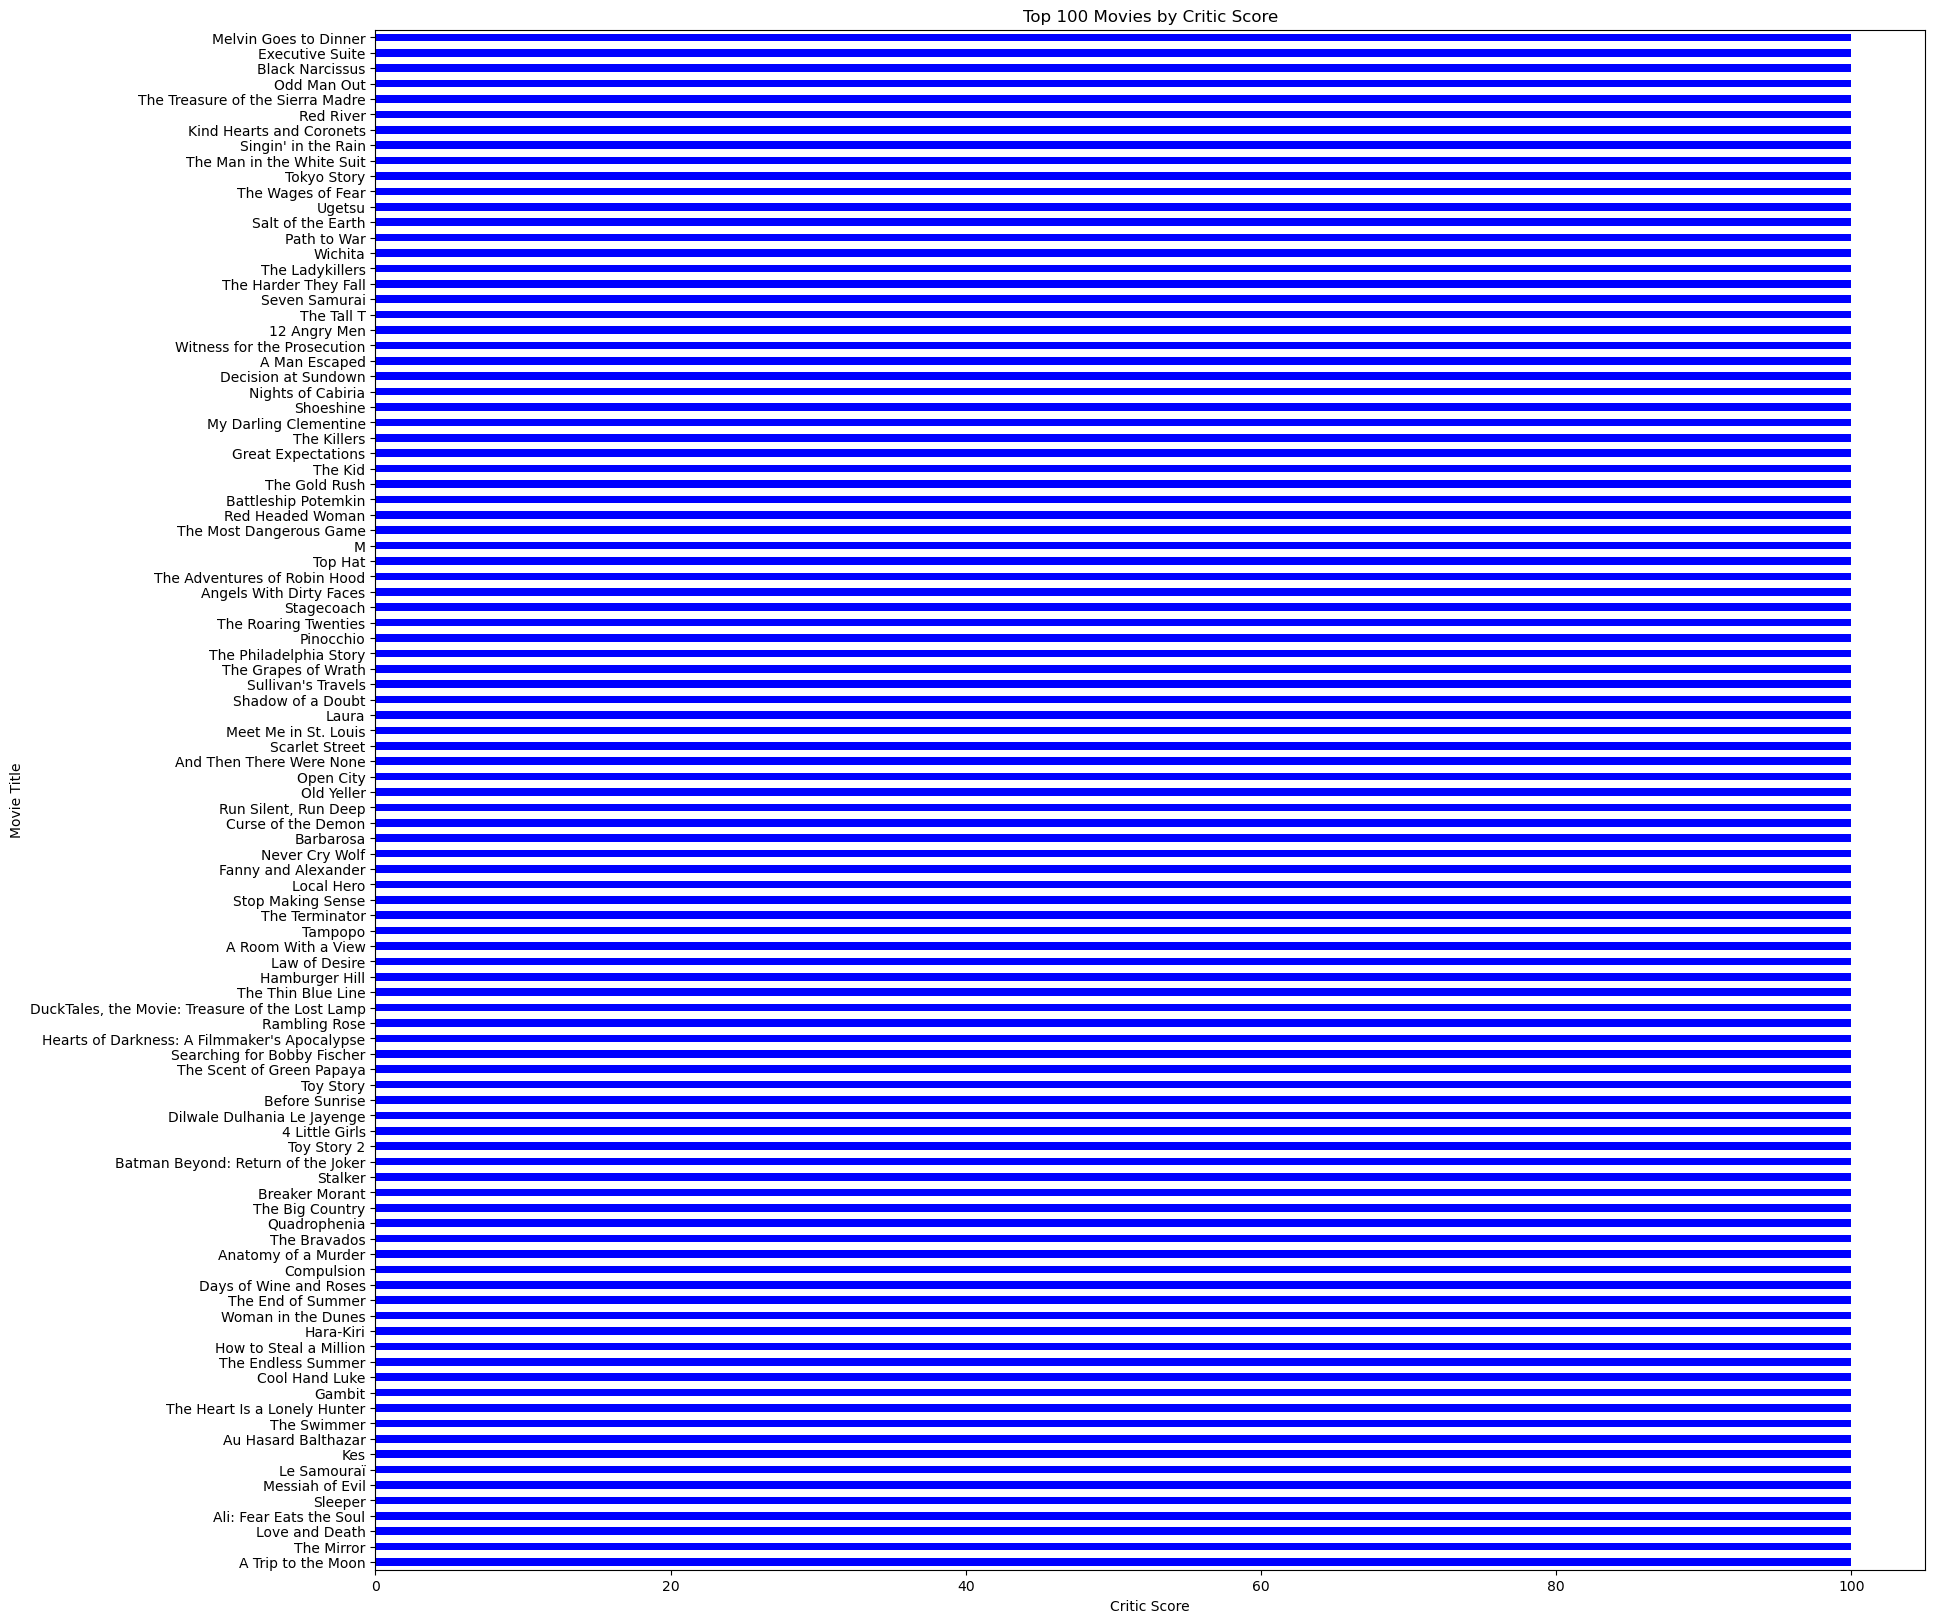

In [ ]:
# Bar chart for Top 100 Movies by Critic Score
plt.figure(figsize=(20, 20))
top_100_critic.set_index('movie_title')['critic_score'].sort_values().plot(kind='barh', color='blue')
plt.title('Top 100 Movies by Critic Score')
plt.xlabel('Critic Score')
plt.ylabel('Movie Title')
plt.show()


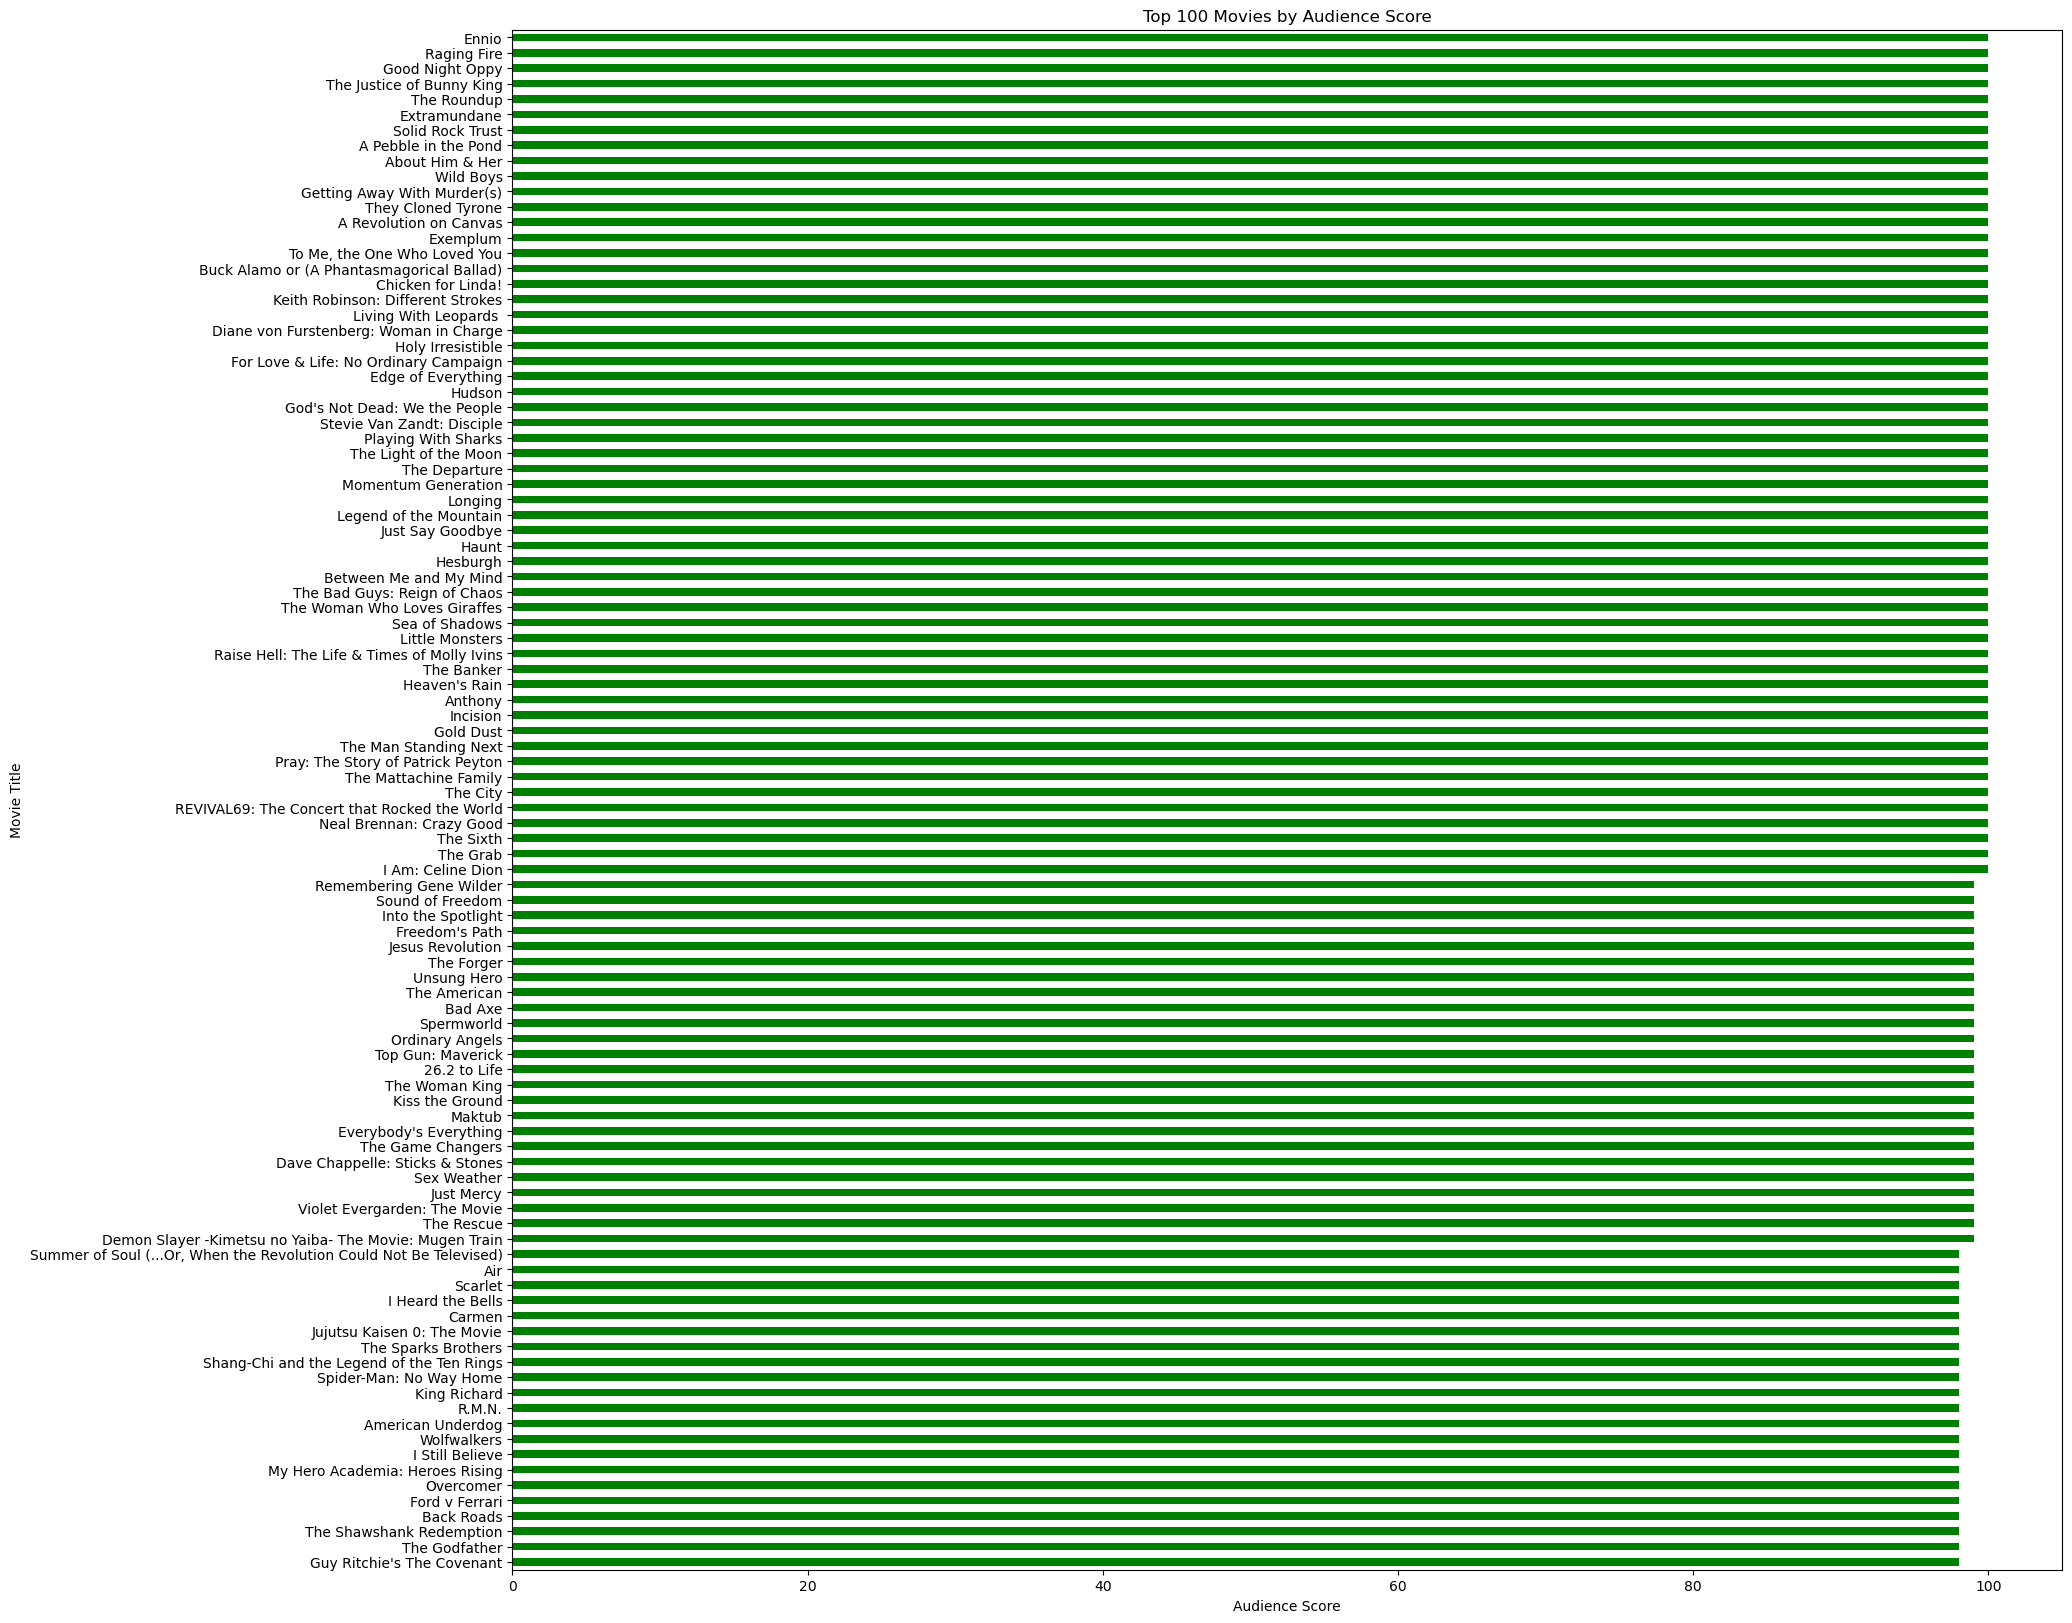

In [ ]:
# Bar chart for Top 100 Movies by Audience Score
plt.figure(figsize=(20, 20))
top_100_audience.set_index('movie_title')['audience_score'].sort_values().plot(kind='barh', color='green')
plt.title('Top 100 Movies by Audience Score')
plt.xlabel('Audience Score')
plt.ylabel('Movie Title')
plt.show()


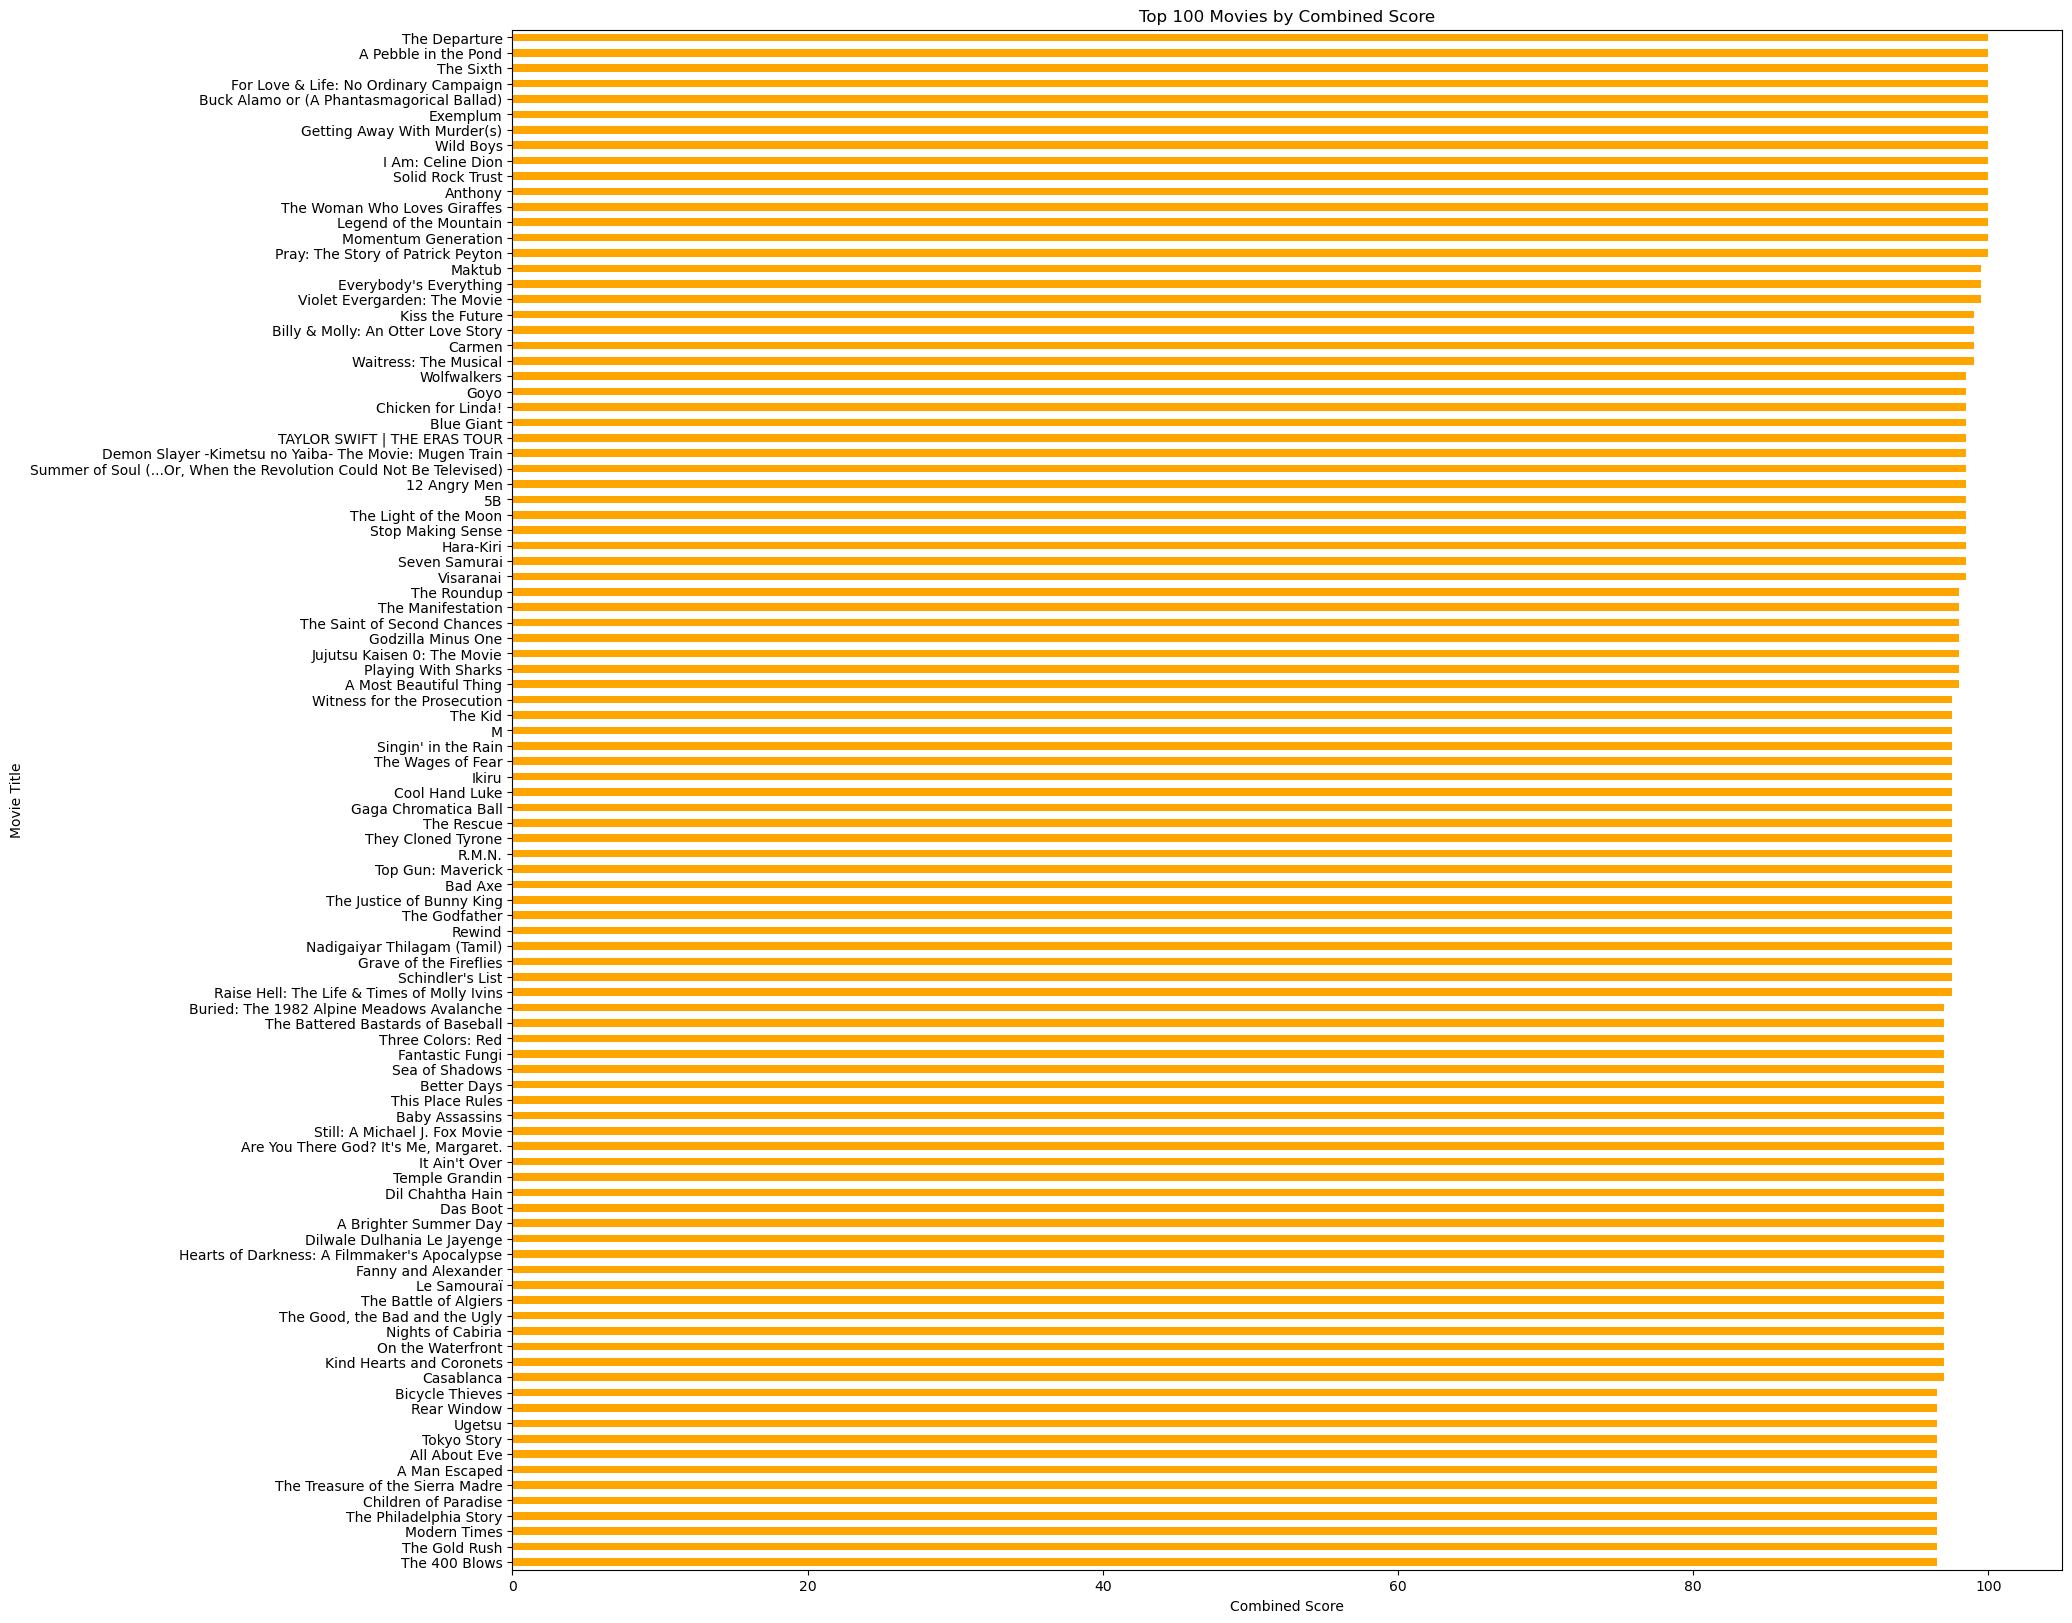

In [ ]:
# Bar chart for Top 100 Movies by Combined Score
plt.figure(figsize=(20, 20))
top_100_combined.set_index('movie_title')['combined_score'].sort_values().plot(kind='barh', color='orange')
plt.title('Top 100 Movies by Combined Score')
plt.xlabel('Combined Score')
plt.ylabel('Movie Title')
plt.show()

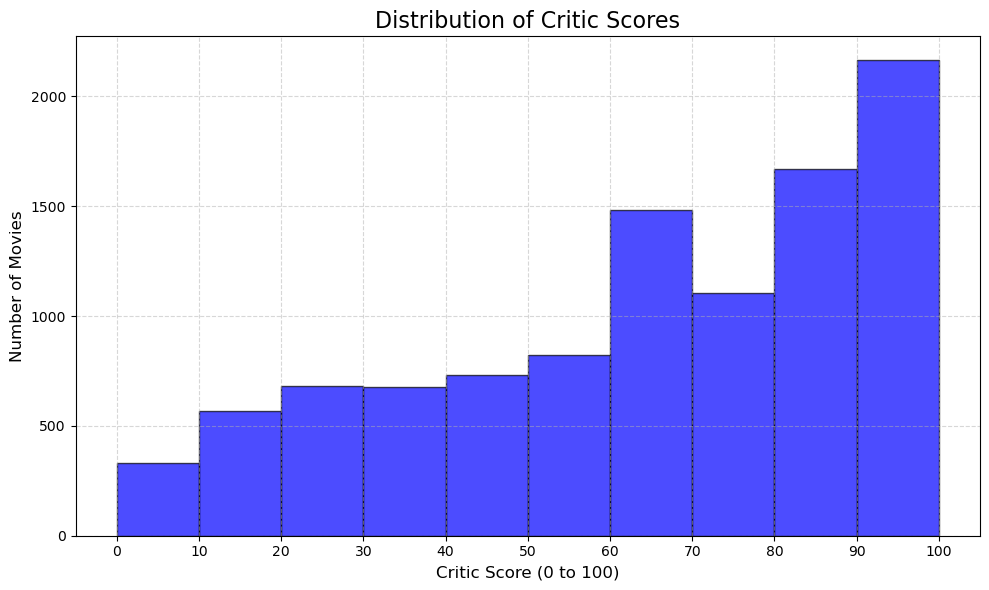

In [ ]:
# Distribution of Critic Scores
plt.figure(figsize=(10, 6))
plt.hist(movies_cleaned['critic_score'], bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Critic Scores', fontsize=16)
plt.xlabel('Critic Score (0 to 100)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 110, 10))  # Ensure x-axis ticks at every 10th score
plt.tight_layout()
plt.show()

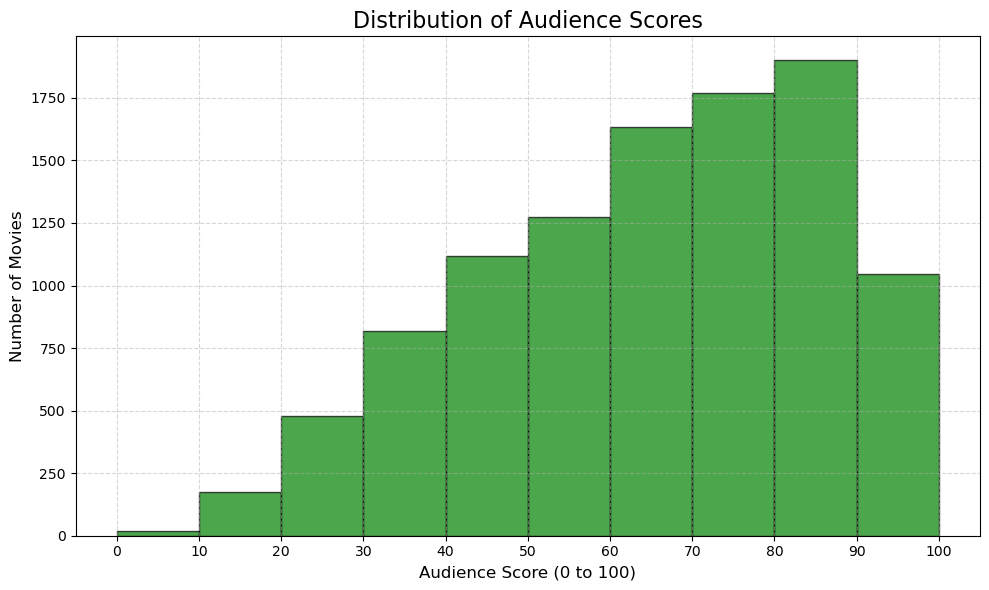

In [ ]:
# Distribution of Audience Scores
plt.figure(figsize=(10, 6))
plt.hist(movies_cleaned['audience_score'], bins=10, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of Audience Scores', fontsize=16)
plt.xlabel('Audience Score (0 to 100)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 110, 10))  # Ensure x-axis ticks at every 10th score
plt.tight_layout()
plt.show()


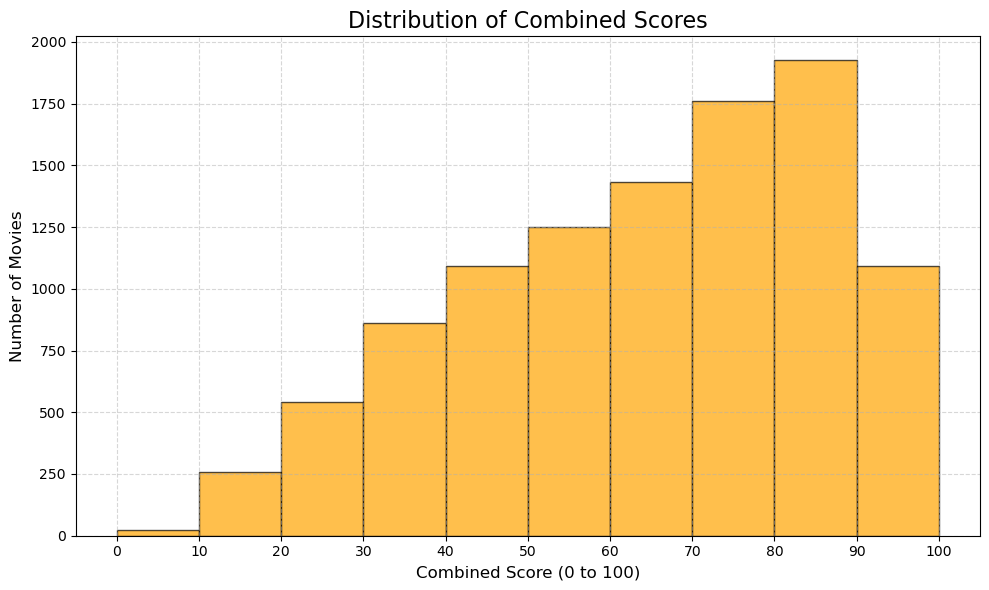

In [ ]:
#  Distribution of Combined Scores
plt.figure(figsize=(10, 6))
plt.hist(movies_cleaned['combined_score'], bins=10, color='orange', alpha=0.7, edgecolor='black')
plt.title('Distribution of Combined Scores', fontsize=16)
plt.xlabel('Combined Score (0 to 100)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 110, 10))  # Ensure x-axis ticks at every 10th score
plt.tight_layout()
plt.show()

### Movies analysis

## `user_reviews`

#### Data Dictionary for `user_reviews`

| Column Name       | Data Type | Description                                                                                                 |
| ----------------- | --------- | ----------------------------------------------------------------------------------------------------------- |
| `movieId`         | object    | Unique identifier for each movie.                                                                           |
| `rating`          | float64   | The rating provided by the user for the movie.                                                              |
| `quote`           | object    | The text content of the user review (a short quote or description of their thoughts).                       |
| `reviewId`        | object    | Unique identifier for each user review (may be null or missing in some cases).                              |
| `isVerified`      | bool      | Indicates whether the review was written by a verified user.                                                |
| `isSuperReviewer` | bool      | Indicates whether the user is a "super reviewer" (a frequent or influential reviewer).                      |
| `hasSpoilers`     | bool      | Indicates whether the review contains spoilers.                                                             |
| `hasProfanity`    | bool      | Indicates whether the review contains profanity.                                                            |
| `score`           | float64   | The numeric score (possibly the same as the rating) given by the user.                                      |
| `creationDate`    | object    | The date when the user review was created.                                                                  |
| `userDisplayName` | object    | The display name of the user (may be missing or null in some cases).                                        |
| `userRealm`       | object    | A field indicating the platform or realm of the user (e.g., "RT" for Rotten Tomatoes).                      |
| `userId`          | object    | Unique identifier for the user who wrote the review.                                                        |

In [ ]:
sampled_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14190186 entries, 0 to 14190185
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   movieId          object 
 1   rating           float64
 2   quote            object 
 3   reviewId         object 
 4   isVerified       bool   
 5   isSuperReviewer  bool   
 6   hasSpoilers      bool   
 7   hasProfanity     bool   
 8   score            float64
 9   creationDate     object 
 10  userDisplayName  object 
 11  userRealm        object 
 12  userId           object 
dtypes: bool(4), float64(2), object(7)
memory usage: 1.0+ GB


In [ ]:
sampled_user_reviews.head()

,movieId,rating,quote,reviewId,isVerified,isSuperReviewer,hasSpoilers,hasProfanity,score,creationDate,userDisplayName,userRealm,userId
0,002b3426-442b-305d-b6ce-804ba1ab7250,3.5,[img]http://www.metacritic.com/media/film/titl...,NaN,False,False,False,False,3.5,2005-05-16,NaN,RT,900769621
1,002b3426-442b-305d-b6ce-804ba1ab7250,5.0,Got a new movie to watch: The Perfect Catch (A...,NaN,False,False,False,False,5.0,2005-10-14,NaN,RT,900811747
2,002b3426-442b-305d-b6ce-804ba1ab7250,3.5,Definately a sports movie for girls... Someone...,NaN,False,False,False,False,3.5,2005-04-13,NaN,RT,900778000
3,002b3426-442b-305d-b6ce-804ba1ab7250,2.0,"Drew Barrymore (granted, not my favorite actre...",NaN,False,False,False,False,2.0,2005-04-22,NaN,RT,900779092
4,002b3426-442b-305d-b6ce-804ba1ab7250,3.0,I watched [b]Fever Pitch[/b] because last nigh...,NaN,False,False,False,False,3.0,2005-09-15,NaN,RT,900620077


In [ ]:
# Check basic info about the dataset
print("Dataset Info:")
print(sampled_user_reviews.info())

# Check for missing values in each column
print("\nMissing values for each column:")
print(sampled_user_reviews.isna().sum())

# Check value counts for each column
for column in sampled_user_reviews.columns:
    print(f"\nValue counts for column: {column}")
    print(sampled_user_reviews[column].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14190186 entries, 0 to 14190185
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   movieId          object 
 1   rating           float64
 2   quote            object 
 3   reviewId         object 
 4   isVerified       bool   
 5   isSuperReviewer  bool   
 6   hasSpoilers      bool   
 7   hasProfanity     bool   
 8   score            float64
 9   creationDate     object 
 10  userDisplayName  object 
 11  userRealm        object 
 12  userId           object 
dtypes: bool(4), float64(2), object(7)
memory usage: 1.0+ GB
None

Missing values for each column:
movieId                   0
rating                    0
quote                     0
reviewId           10031581
isVerified                0
isSuperReviewer           0
hasSpoilers               0
hasProfanity              0
score                     0
creationDate              0
userDisplayName    13672566
userRealm     

In [ ]:
# Drop unnecessary columns
sampled_user_reviews_cleaned = sampled_user_reviews.copy()
sampled_user_reviews_cleaned = sampled_user_reviews_cleaned.drop(['reviewId', 'userDisplayName', 'isVerified', 'hasSpoilers', 'userRealm', 'hasProfanity', 'isSuperReviewer', 'rating'], axis=1)

print(sampled_user_reviews_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14190186 entries, 0 to 14190185
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   movieId       object 
 1   quote         object 
 2   score         float64
 3   creationDate  object 
 4   userId        object 
dtypes: float64(1), object(4)
memory usage: 541.3+ MB
None


In [ ]:
sampled_user_reviews_cleaned.columns = [camel_to_snake_manual(col) for col in sampled_user_reviews_cleaned.columns]
sampled_user_reviews_cleaned.columns

Index(['movie_id', 'quote', 'score', 'creation_date', 'user_id'], dtype='object')

In [ ]:
sampled_user_reviews_cleaned['score'].unique()

array([3.5, 5. , 2. , 3. , 4. , 4.5, 2.5, 1.5, 1. , 0.5])

In [ ]:
def standardize_score(score):
    # Convert the 0.5-5 scale to 1-10 scale and round to nearest integer
    return min(10, max(1, round(score * 2)))

# Apply the function to create the new column
sampled_user_reviews_cleaned['standardized_score'] = sampled_user_reviews_cleaned['score'].apply(standardize_score)

# Check the unique values
print(sorted(sampled_user_reviews_cleaned['standardized_score'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
sampled_user_reviews_cleaned.columns

Index(['movie_id', 'quote', 'score', 'creation_date', 'user_id',
       'standardized_score'],
      dtype='object')

In [ ]:
# Convert 'creation_date' to datetime format
sampled_user_reviews_cleaned['creation_date'] = pd.to_datetime(sampled_user_reviews_cleaned['creation_date'], errors='coerce')

# Extract the year from 'creation_date'
sampled_user_reviews_cleaned['creation_year'] = sampled_user_reviews_cleaned['creation_date'].dt.year

# Drop the 'creation_date' column
sampled_user_reviews_cleaned.drop(columns=['creation_date'], inplace=True)

print(sampled_user_reviews_cleaned.head())

                               movie_id  \
0  002b3426-442b-305d-b6ce-804ba1ab7250   
1  002b3426-442b-305d-b6ce-804ba1ab7250   
2  002b3426-442b-305d-b6ce-804ba1ab7250   
3  002b3426-442b-305d-b6ce-804ba1ab7250   
4  002b3426-442b-305d-b6ce-804ba1ab7250   

                                               quote  score    user_id  \
0  [img]http://www.metacritic.com/media/film/titl...    3.5  900769621   
1  Got a new movie to watch: The Perfect Catch (A...    5.0  900811747   
2  Definately a sports movie for girls... Someone...    3.5  900778000   
3  Drew Barrymore (granted, not my favorite actre...    2.0  900779092   
4  I watched [b]Fever Pitch[/b] because last nigh...    3.0  900620077   

   standardized_score  creation_year  
0                   7           2005  
1                  10           2005  
2                   7           2005  
3                   4           2005  
4                   6           2005  


In [ ]:
sampled_user_reviews_cleaned['creation_year'].value_counts()

creation_year
2007    6188738
2008    2502854
2006    1165136
2009     968111
2010     578955
2012     544914
2011     449620
2013     310813
2014     205848
2023     154671
2015     150273
2020     142749
2019     129878
2016     123311
2022     118346
2021     118062
2018     101358
2017      99035
2024      80582
2005      32105
2004      22568
2003       2189
2002         42
1996          9
1999          7
2001          5
2000          4
1998          2
1997          1
Name: count, dtype: int64

In [ ]:
sampled_user_reviews_cleaned['user_id'].describe()

count                                 14190186
unique                                 2652768
top       20f97638-9460-4b49-a86c-4f730c64ca60
freq                                      4009
Name: user_id, dtype: object

In [ ]:
sampled_user_reviews_cleaned.head()

,movie_id,quote,score,user_id,standardized_score,creation_year
0,002b3426-442b-305d-b6ce-804ba1ab7250,[img]http://www.metacritic.com/media/film/titl...,3.5,900769621,7,2005
1,002b3426-442b-305d-b6ce-804ba1ab7250,Got a new movie to watch: The Perfect Catch (A...,5.0,900811747,10,2005
2,002b3426-442b-305d-b6ce-804ba1ab7250,Definately a sports movie for girls... Someone...,3.5,900778000,7,2005
3,002b3426-442b-305d-b6ce-804ba1ab7250,"Drew Barrymore (granted, not my favorite actre...",2.0,900779092,4,2005
4,002b3426-442b-305d-b6ce-804ba1ab7250,I watched [b]Fever Pitch[/b] because last nigh...,3.0,900620077,6,2005


In [ ]:
# Save a cleaned version of sampled_user_reviews
sampled_user_reviews_cleaned.to_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_user_reviews_cleaned.csv", index=False)


In [ ]:
# Count unique movie_ids in each dataset
unique_movie_ids_movies = movies_cleaned['movie_id'].nunique()
unique_movie_ids_critics = critic_reviews_cleaned['movie_id'].nunique()
unique_movie_ids_sampled_users = sampled_user_reviews_cleaned['movie_id'].nunique()

# Display the results
print(f"Unique movie_ids in movies_cleaned: {unique_movie_ids_movies}")
print(f"Unique movie_ids in critic_reviews_cleaned: {unique_movie_ids_critics}")
print(f"Unique movie_ids in sampled_user_reviews_cleaned: {unique_movie_ids_sampled_users}")


Unique movie_ids in movies_cleaned: 10233
Unique movie_ids in critic_reviews_cleaned: 10227
Unique movie_ids in sampled_user_reviews_cleaned: 10197


### User Reviews Analysis

In [ ]:
# Find movie_ids present in movies_cleaned but not in critic_reviews_cleaned
movies_not_in_critics = set(movies_cleaned['movie_id']) - set(critic_reviews_cleaned['movie_id'])

# Find movie_ids present in movies_cleaned but not in sampled_user_reviews_cleaned
movies_not_in_users = set(movies_cleaned['movie_id']) - set(sampled_user_reviews_cleaned['movie_id'])

# Find movie_ids in critic_reviews_cleaned but not in movies_cleaned
critics_not_in_movies = set(critic_reviews_cleaned['movie_id']) - set(movies_cleaned['movie_id'])

# Find movie_ids in sampled_user_reviews_cleaned but not in movies_cleaned
users_not_in_movies = set(sampled_user_reviews_cleaned['movie_id']) - set(movies_cleaned['movie_id'])

# Display the differences
print(f"Movies in movies_cleaned but not in critic_reviews_cleaned: {len(movies_not_in_critics)}")
print(f"Movies in movies_cleaned but not in sampled_user_reviews_cleaned: {len(movies_not_in_users)}")
print(f"Movies in critic_reviews_cleaned but not in movies_cleaned: {len(critics_not_in_movies)}")
print(f"Movies in sampled_user_reviews_cleaned but not in movies_cleaned: {len(users_not_in_movies)}")


Movies in movies_cleaned but not in critic_reviews_cleaned: 6
Movies in movies_cleaned but not in sampled_user_reviews_cleaned: 36
Movies in critic_reviews_cleaned but not in movies_cleaned: 0
Movies in sampled_user_reviews_cleaned but not in movies_cleaned: 0


In [ ]:
# Count unique movie_ids in each cleaned dataset
unique_movie_ids_movies = movies_cleaned['movie_id'].nunique()
unique_movie_ids_critics = critic_reviews_cleaned['movie_id'].nunique()
unique_movie_ids_sampled_users = sampled_user_reviews_cleaned['movie_id'].nunique()

# Display the results
print(f"Unique movie_ids in movies_cleaned: {unique_movie_ids_movies}")
print(f"Unique movie_ids in critic_reviews_cleaned: {unique_movie_ids_critics}")
print(f"Unique movie_ids in sampled_user_reviews_cleaned: {unique_movie_ids_sampled_users}")


Unique movie_ids in movies_cleaned: 10233
Unique movie_ids in critic_reviews_cleaned: 10227
Unique movie_ids in sampled_user_reviews_cleaned: 10197


# Merged Datasets

In [ ]:
import pandas as pd
import numpy as np
import ast

# File paths
movies_file = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\movies_cleaned.csv"
critic_reviews_file = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\critic_reviews_cleaned.csv"
user_reviews_file = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\sampled_user_reviews_cleaned.csv"

# Read the datasets
print("Reading datasets...")
movies_cleaned = pd.read_csv(movies_file)
critic_reviews_cleaned = pd.read_csv(critic_reviews_file)
sampled_user_reviews_cleaned = pd.read_csv(user_reviews_file)

# Function to safely convert to list
def safe_to_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    elif pd.isna(x):
        return []
    else:
        return [x]

# Calculate total reviews and weights
total_user_reviews = sampled_user_reviews_cleaned.shape[0]
total_critic_reviews = critic_reviews_cleaned.shape[0]
user_weight = 0.5  # Equal weight to users and critics
critic_weight = 0.5

# Aggregate critic reviews
print("Aggregating critic reviews...")
critic_agg = critic_reviews_cleaned.groupby('movie_id').agg({
    'standardized_score': 'mean',
    'critic_name': 'count',
    'quote': lambda x: x.dropna().tolist()
}).rename(columns={'standardized_score': 'avg_critic_score_new', 'critic_name': 'critic_review_count', 'quote': 'critic_quotes'})

# Aggregate user reviews
print("Aggregating user reviews...")
user_agg = sampled_user_reviews_cleaned.groupby('movie_id').agg({
    'standardized_score': 'mean',
    'user_id': 'count',
    'quote': lambda x: x.dropna().tolist()
}).rename(columns={'standardized_score': 'avg_user_score_new', 'user_id': 'user_review_count', 'quote': 'user_quotes'})

# Merge all datasets
print("Merging datasets...")
merged = movies_cleaned.merge(critic_agg, on='movie_id', how='left')
merged = merged.merge(user_agg, on='movie_id', how='left')

# Calculate unweighted average score
merged['unweighted_avg_score'] = (
    merged['avg_user_score_new'].fillna(0) +
    merged['avg_critic_score_new'].fillna(0)
) / 2

# Calculate weighted average score
merged['weighted_avg_score'] = (
    (merged['avg_user_score_new'].fillna(0) * user_weight) +
    (merged['avg_critic_score_new'].fillna(0) * critic_weight)
) / (user_weight + critic_weight)

# Safely convert quote columns to lists
merged['critic_quotes'] = merged['critic_quotes'].apply(safe_to_list)
merged['user_quotes'] = merged['user_quotes'].apply(safe_to_list)

# Combine critic and user quotes
merged['all_quotes'] = merged.apply(lambda row: row['critic_quotes'] + row['user_quotes'], axis=1)

# Clean up the dataset
merged = merged.drop(columns=['critic_quotes', 'user_quotes'])

print("Final dataset shape:", merged.shape)
print("\nColumn names:", merged.columns.tolist())

# Display info about quotes
print("\nAverage number of quotes per movie:", merged['all_quotes'].apply(len).mean())
print("Max number of quotes for a movie:", merged['all_quotes'].apply(len).max())
print("Number of movies with no quotes:", (merged['all_quotes'].apply(len) == 0).sum())

# Save the merged dataset
output_file = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\merged_movies_with_quotes.csv"
merged.to_csv(output_file, index=False)
print(f"\nMerged dataset saved to: {output_file}")

# Display a sample movie with its quotes and scores
sample_movie = merged.loc[merged['all_quotes'].apply(len) > 0].sample(1).iloc[0]
print(f"\nSample movie: {sample_movie['movie_title']} ({sample_movie['movie_year']})")
print(f"Number of quotes: {len(sample_movie['all_quotes'])}")
print(f"Original audience score (0-100): {sample_movie['audience_score']:.1f}")
print(f"Original critic score (0-100): {sample_movie['critic_score']:.1f}")
print(f"New average user score (1-10): {sample_movie['avg_user_score_new']:.2f}")
print(f"New average critic score (1-10): {sample_movie['avg_critic_score_new']:.2f}")
print(f"Unweighted average score (1-10): {sample_movie['unweighted_avg_score']:.2f}")
print(f"Weighted average score (1-10): {sample_movie['weighted_avg_score']:.2f}")
print("First 3 quotes:")
for quote in sample_movie['all_quotes'][:3]:
    print(f"- {quote}")

print("\nAnalysis complete. You can now use the merged dataset with quote lists and various score metrics for further analysis.")

Reading datasets...
Aggregating critic reviews...
Aggregating user reviews...
Merging datasets...
Final dataset shape: (10233, 19)

Column names: ['movie_id', 'movie_year', 'movie_title', 'critic_score', 'critic_sentiment', 'audience_score', 'audience_sentiment', 'rating', 'original_language', 'release_year_theaters', 'release_year_streaming', 'runtime_in_minutes', 'avg_critic_score_new', 'critic_review_count', 'avg_user_score_new', 'user_review_count', 'unweighted_avg_score', 'weighted_avg_score', 'all_quotes']

Average number of quotes per movie: 1443.2892602364898
Max number of quotes for a movie: 11199
Number of movies with no quotes: 0

Merged dataset saved to: C:\Users\Marlissa\Downloads\chingu\chingu_datasets\merged_movies_with_quotes.csv

Sample movie: Cadaver (2020)
Number of quotes: 49
Original audience score (0-100): 28.0
Original critic score (0-100): 33.0
New average user score (1-10): 5.22
New average critic score (1-10): 7.78
Unweighted average score (1-10): 6.50
Weighte

In [ ]:
merged_cleaned = merged.copy()

In [ ]:
# Display unique values in the 'rating' column
print(merged_cleaned['rating'].unique())

# Get the value counts and percentages
rating_counts = merged_cleaned['rating'].value_counts(dropna=False)
rating_percentages = merged_cleaned['rating'].value_counts(dropna=False, normalize=True) * 100

# Combine counts and percentages
rating_summary = pd.concat([rating_counts, rating_percentages], axis=1, keys=['Count', 'Percentage'])
rating_summary['Percentage'] = rating_summary['Percentage'].round(2)

print("\nRating Distribution:")
print(rating_summary)

# Check for null values
null_count = merged_cleaned['rating'].isnull().sum()
print(f"\nNumber of null values: {null_count}")

['Unknown' 'G' 'PG' 'PG-13' 'TV' 'R' 'NC-17' 'TV-14']

Rating Distribution:
         Count  Percentage
rating                    
R         3937       38.47
Unknown   2475       24.19
PG-13     2154       21.05
PG        1245       12.17
G          244        2.38
TV          97        0.95
TV-14       54        0.53
NC-17       27        0.26

Number of null values: 0


In [ ]:
# Calculate the difference between weighted and unweighted scores
if 'weighted_avg_score' in merged_cleaned.columns and 'unweighted_avg_score' in merged_cleaned.columns:
    merged_cleaned['score_difference'] = merged_cleaned['weighted_avg_score'] - merged_cleaned['unweighted_avg_score']

    # Basic statistical comparison
    print("Comparison of Weighted and Unweighted Scores:")
    print(merged_cleaned[['unweighted_avg_score', 'weighted_avg_score', 'score_difference']].describe())

    # Check if all values are exactly the same
    are_identical = np.allclose(merged_cleaned['unweighted_avg_score'], merged_cleaned['weighted_avg_score'])
    print(f"\nAre all weighted and unweighted scores identical? {are_identical}")

    # If they're not identical, let's see the distribution of differences
    if not are_identical:
        print("\nDistribution of differences (absolute values):")
        print(merged_cleaned['score_difference'].abs().value_counts(bins=10, normalize=True).sort_index())

    # Check for any significant differences
    significant_diff = merged_cleaned[abs(merged_cleaned['score_difference']) > 0.01]
    print(f"\nNumber of movies with difference > 0.01: {len(significant_diff)}")

    if len(significant_diff) > 0:
        print("\nSample of movies with significant differences:")
        print(significant_diff[['movie_title', 'unweighted_avg_score', 'weighted_avg_score', 'score_difference']].head())
else:
    print("The columns 'weighted_avg_score' or 'unweighted_avg_score' do not exist in the dataset.")


Comparison of Weighted and Unweighted Scores:
       unweighted_avg_score  weighted_avg_score  score_difference
count          10233.000000        10233.000000           10233.0
mean               7.496500            7.496500               0.0
std                1.095818            1.095818               0.0
min                1.833333            1.833333               0.0
25%                6.837808            6.837808               0.0
50%                7.631534            7.631534               0.0
75%                8.291087            8.291087               0.0
max               10.000000           10.000000               0.0

Are all weighted and unweighted scores identical? True

Number of movies with difference > 0.01: 0


In [ ]:
# Remove the redundant column
merged_cleaned = merged_cleaned.drop(columns=['weighted_avg_score'])

# Rename the remaining column for clarity
merged_cleaned = merged_cleaned.rename(columns={'unweighted_avg_score': 'avg_score'})

In [ ]:
merged_cleaned.columns

Index(['movie_id', 'movie_year', 'movie_title', 'critic_score',
       'critic_sentiment', 'audience_score', 'audience_sentiment', 'rating',
       'original_language', 'release_year_theaters', 'release_year_streaming',
       'runtime_in_minutes', 'avg_critic_score_new', 'critic_review_count',
       'avg_user_score_new', 'user_review_count', 'avg_score', 'all_quotes',
       'score_difference'],
      dtype='object')

In [ ]:
merged_cleaned.head()

,movie_id,movie_year,movie_title,critic_score,critic_sentiment,audience_score,audience_sentiment,rating,original_language,release_year_theaters,release_year_streaming,runtime_in_minutes,avg_critic_score_new,critic_review_count,avg_user_score_new,user_review_count,avg_score,all_quotes,score_difference
0,281004c8-bbc3-3522-8246-26ee44469bb4,1902,A Trip to the Moon,100.0,positive,90.0,positive,Unknown,French,1902.0,2016,14.0,9.428571,14.0,8.538931,655.0,8.983751,[The primitive silent landmark has more charm ...,0.0
1,ac173b27-b71a-34b3-9888-5304a0e165e0,1915,The Birth of a Nation,91.0,positive,47.0,negative,Unknown,Unknown,1915.0,2016,190.0,8.750000,36.0,6.221034,561.0,7.485517,"[A controversial, explicitly racist, but landm...",0.0
2,96f91c04-5e32-39b2-805f-4c1d1bcb3b1b,1921,The Cabinet of Dr. Caligari,96.0,positive,89.0,positive,Unknown,German,1921.0,2016,69.0,9.863014,73.0,8.431373,1683.0,9.147193,[The sheer audacity of the film's physical and...,0.0
3,b70c2dc6-41e7-3240-a38f-5f5e5018eeb1,1921,The Kid,100.0,positive,95.0,positive,Unknown,English,1921.0,2016,60.0,9.441860,43.0,8.806452,775.0,9.124156,[Combinando com perfeio toques comoventes e en...,0.0
4,13101368-55d8-30a1-9d41-4271211defbb,1922,Nosferatu,97.0,positive,87.0,positive,Unknown,German,1922.0,2008,65.0,9.578947,57.0,8.314728,2777.0,8.946838,"[It's remarkable, by contrast with all the fil...",0.0


In [ ]:
# List of columns to drop
columns_to_drop = [
    'critic_score',
    'audience_score',
    'critic_sentiment',
    'audience_sentiment',
    'release_year_streaming',
    'score_difference',
    'release_year'  # Dropping release_year
]

# Check if the columns to be dropped actually exist
columns_to_drop = [col for col in columns_to_drop if col in merged_cleaned.columns]

# Drop the specified columns
merged_cleaned = merged_cleaned.drop(columns=columns_to_drop)

# Rename columns for clarity
merged_cleaned = merged_cleaned.rename(columns={
    'avg_critic_score_new': 'critic_score',
    'avg_user_score_new': 'user_score',
    'avg_score': 'average_combined_score',
    'release_year_theaters': 'release_year'
})

# Convert data types and round floating-point numbers
merged_cleaned['runtime_in_minutes'] = merged_cleaned['runtime_in_minutes'].fillna(0).astype(int)
merged_cleaned['critic_score'] = merged_cleaned['critic_score'].round(2)
merged_cleaned['user_score'] = merged_cleaned['user_score'].round(2)
merged_cleaned['average_combined_score'] = merged_cleaned['average_combined_score'].round(2)
merged_cleaned['critic_review_count'] = merged_cleaned['critic_review_count'].fillna(0).astype(int)
merged_cleaned['user_review_count'] = merged_cleaned['user_review_count'].fillna(0).astype(int)

# Reorder columns for better readability (without release_year)
column_order = [
    'movie_id', 'movie_year', 'movie_title', 'rating', 'original_language',
    'runtime_in_minutes', 'critic_score', 'user_score',
    'average_combined_score', 'critic_review_count', 'user_review_count', 'all_quotes'
]
merged_cleaned = merged_cleaned[column_order]

# Display the first few rows of the cleaned dataset
print(merged_cleaned.head())

# Display info about the cleaned dataset
print("\nDataset Info:")
print(merged_cleaned.info())

# Save the cleaned dataset
output_file = r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\merged_dataset_final.csv"
merged_cleaned.to_csv(output_file, index=False)
print(f"\nCleaned dataset saved to: {output_file}")


                               movie_id  movie_year  \
0  281004c8-bbc3-3522-8246-26ee44469bb4        1902   
1  ac173b27-b71a-34b3-9888-5304a0e165e0        1915   
2  96f91c04-5e32-39b2-805f-4c1d1bcb3b1b        1921   
3  b70c2dc6-41e7-3240-a38f-5f5e5018eeb1        1921   
4  13101368-55d8-30a1-9d41-4271211defbb        1922   

                   movie_title   rating original_language  runtime_in_minutes  \
0           A Trip to the Moon  Unknown            French                  14   
1        The Birth of a Nation  Unknown           Unknown                 190   
2  The Cabinet of Dr. Caligari  Unknown            German                  69   
3                      The Kid  Unknown           English                  60   
4                    Nosferatu  Unknown            German                  65   

   critic_score  user_score  average_combined_score  critic_review_count  \
0          9.43        8.54                    8.98                   14   
1          8.75        6.22   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_id                10233 non-null  object 
 1   movie_year              10233 non-null  int64  
 2   movie_title             10233 non-null  object 
 3   rating                  10233 non-null  object 
 4   original_language       10233 non-null  object 
 5   runtime_in_minutes      10233 non-null  int32  
 6   critic_score            10227 non-null  float64
 7   user_score              10197 non-null  float64
 8   average_combined_score  10233 non-null  float64
 9   critic_review_count     10233 non-null  int32  
 10  user_review_count       10233 non-null  int32  
 11  all_quotes              10233 non-null  object 
dtypes: float64(3), int32(3), int64(1), object(5)
memory usage: 839.6+ KB
None


,movie_id,movie_year,movie_title,rating,original_language,runtime_in_minutes,critic_score,user_score,average_combined_score,critic_review_count,user_review_count,all_quotes
0,281004c8-bbc3-3522-8246-26ee44469bb4,1902,A Trip to the Moon,Unknown,French,14,9.43,8.54,8.98,14,655,[The primitive silent landmark has more charm ...
1,ac173b27-b71a-34b3-9888-5304a0e165e0,1915,The Birth of a Nation,Unknown,Unknown,190,8.75,6.22,7.49,36,561,"[A controversial, explicitly racist, but landm..."
2,96f91c04-5e32-39b2-805f-4c1d1bcb3b1b,1921,The Cabinet of Dr. Caligari,Unknown,German,69,9.86,8.43,9.15,73,1683,[The sheer audacity of the film's physical and...
3,b70c2dc6-41e7-3240-a38f-5f5e5018eeb1,1921,The Kid,Unknown,English,60,9.44,8.81,9.12,43,775,[Combinando com perfeio toques comoventes e en...
4,13101368-55d8-30a1-9d41-4271211defbb,1922,Nosferatu,Unknown,German,65,9.58,8.31,8.95,57,2777,"[It's remarkable, by contrast with all the fil..."


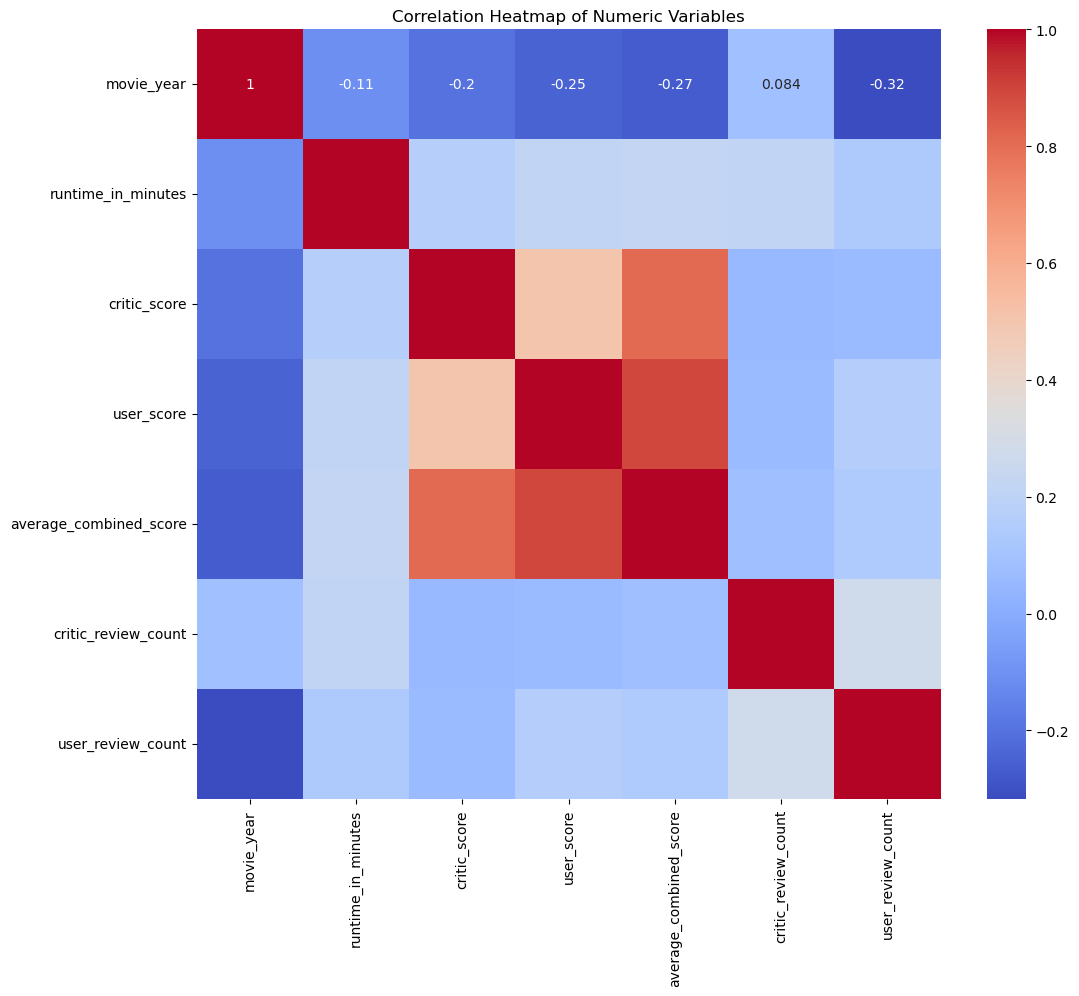

KeyError: 'release_year'

<Figure size 1200x600 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = merged_cleaned.copy()

# Display basic info
print(df.info())

# Show first few rows
display(df.head())

# Create a correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

# Plot average scores over time
plt.figure(figsize=(12,6))
df.groupby('release_year')[['critic_score', 'user_score']].mean().plot()
plt.title("Average Critic and User Scores Over Time")
plt.ylabel("Score")
plt.show()

In [ ]:

# Display basic info
print("Dataset Overview:")
display(df.head())

# Scores Distribution
fig = px.histogram(df, x="average_combined_score", nbins=20, title="Distribution of Average Combined Scores")
fig.show()

# Function to filter data by year range
def filter_by_year(df, start_year, end_year):
    return df[(df['release_year'] >= start_year) & (df['release_year'] <= end_year)]

# Critic vs User Scores
filtered_df = filter_by_year(df, 1990, 2020)  # You can change these years as needed
fig = px.scatter(filtered_df, x="critic_score", y="user_score",
                 hover_data=["movie_title"],
                 title="Critic Scores vs User Scores (1990-2020)")
fig.show()

# Additional visualizations

# Top 10 movies by average combined score
top_10 = df.nlargest(10, 'average_combined_score')
plt.figure(figsize=(12, 6))
sns.barplot(x='average_combined_score', y='movie_title', data=top_10)
plt.title('Top 10 Movies by Average Combined Score')
plt.xlabel('Average Combined Score')
plt.ylabel('Movie Title')
plt.show()

# Scores over time
yearly_avg = df.groupby('release_year')[['critic_score', 'user_score']].mean()
plt.figure(figsize=(12, 6))
yearly_avg.plot(figsize=(12, 6))
plt.title('Average Critic and User Scores Over Time')
plt.xlabel('Release Year')
plt.ylabel('Score')
plt.legend(['Critic Score', 'User Score'])
plt.show()

# Correlation heatmap
corr_matrix = df[['runtime_in_minutes', 'critic_score', 'user_score', 'average_combined_score', 'critic_review_count', 'user_review_count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()